In [1]:
from __future__ import print_function

import mxnet as mx
from mxnet import nd, autograd, sym, mod
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

from src.fetch_mnist import preprocessed_mnist

### Useful links

[A Practitioner’s Guide to MXNet](http://home.cse.ust.hk/~xshiab/data/MXNet.pdf)

[An introduction to the MXNet API](https://becominghuman.ai/an-introduction-to-the-mxnet-api-part-1-848febdcf8ab) blog post series on Medium

[MXNet the straight dope](https://github.com/zackchase/mxnet-the-straight-dope) - jupyter-notebook based deep learning textbook

#### Preparing data

Note that MXNet uses its own NDArrays, so `numpy` arrays need to be converted to that. We also use `mxnet.io` NDArrayIter class that splits data into batches.

In [2]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = preprocessed_mnist(random_state=0)
X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test, test_size=0.5) 
category_count = len(np.unique(y_train))

def data_iter(X, y, batch_size=500):
  batch_size = min(X.shape[0], batch_size)
  return mx.io.NDArrayIter(
    data=nd.array(X),
    label=nd.array(y),
    batch_size=batch_size)

train_iter = data_iter(X_train, y_train)
valid_iter = data_iter(X_valid, y_valid)
test_iter = data_iter(X_test, y_test)

/home/semantive/Projects/notebooks/examples-counterexamples/venv/lib/python3.5/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


## Logistic regression with softmax using `module` API

`mxnet.sym` is a module for symbols - nodes in computation graph (they correspond to tensors from Theano/Tensorflow).

The module also contains utilities that can be used for defining layers.

`mxnet.mod` contains classes for *Modules* - they provide high-level functionalities a'la `scikit-learn` estimators. Modules can be built with symbols, and they automatically infer weights from layers.

Below is an example of simple *Module* that performs logistic regression (it uses minibatch gradient descent for optimization).

In [3]:
data = sym.Variable('data')
softmax_input = sym.FullyConnected(data, name='softmax_input', num_hidden=category_count)
softmax_output = sym.SoftmaxOutput(softmax_input, name='softmax')

logistic_classifier = mod.Module(symbol=softmax_output)

The following cell contains code that can be passed to our Module's `fit` method. It is used to save per-batch metric (here accuracy is used).

In [4]:
from mxnet.callback import LogValidationMetricsCallback

def log_to_list(lst, period=None, data_type='Train', log_output=False):
    def condition(nbatch):
      if period == None:
        return nbatch == 0
      else:
        return nbatch % period == 0
  
    def _callback(param):
        """The checkpoint function."""
        if condition(param.nbatch) and param.eval_metric is not None:
            name_value = param.eval_metric.get_name_value()
            for name, value in name_value:
                message_args = (param.epoch, param.nbatch, data_type, name, value)
                message = 'Iter[{}] Batch[{}] {}-{}={}'.format(*message_args)
                if log_output:
                  print(message)
                lst.append((message, message_args))
    return _callback

#### Training

In [5]:
train_log_list = []
eval_log_list = []

num_epoch = 100 

In [6]:
%time logistic_classifier.fit(\
  train_iter,\
  eval_data=valid_iter,\
  eval_metric='ce',\
  batch_end_callback=log_to_list(train_log_list),\
  eval_batch_end_callback=log_to_list(eval_log_list, data_type='Valid'),\
  num_epoch=num_epoch)

CPU times: user 51.9 s, sys: 1.9 s, total: 53.8 s
Wall time: 22.5 s


In [7]:
y_test_pred_proba = logistic_classifier.predict(test_iter)
y_test_pred = nd.argmax(y_test_pred_proba, axis=1)

In [8]:
from sklearn.metrics import accuracy_score

def evaluate_classifier(clf, round_to=3):
  datasets = [data_iter(X_train, y_train), data_iter(X_valid, y_valid), data_iter(X_test, y_test)]
  label_sets = [y_train, y_valid, y_test]
  for (set_label, dataset_iter, labels) in zip(['train', 'validation', 'test'], datasets, label_sets):
    y_pred_proba = clf.predict(dataset_iter)
    y_pred = nd.argmax(y_pred_proba, axis=1)

    accuracy = accuracy_score(labels, y_pred.asnumpy())

    print(
      'accuracy on {} set:\n{}'.format(
        set_label,
        round(accuracy, round_to)))

In [9]:
evaluate_classifier(logistic_classifier)

accuracy on train set:
0.929
accuracy on validation set:
0.924
accuracy on test set:
0.919


In [10]:
def get_loss_from_logs(logs):
  return [msg[1][4] for msg in logs]

train_loss = get_loss_from_logs(train_log_list)
eval_loss = get_loss_from_logs(eval_log_list)

## Validation vs training loss 

In [11]:
def plot_train_vs_validation_loss(train_loss, eval_loss, offset=0):
  assert len(train_loss) == len(eval_loss)
  l = len(train_loss)
  rng = np.arange(start=offset, stop=l)
  
  plt.plot(rng, train_loss[offset:], label='train')
  plt.plot(rng, eval_loss[offset:], label='validation')
  plt.legend()
  plt.show()

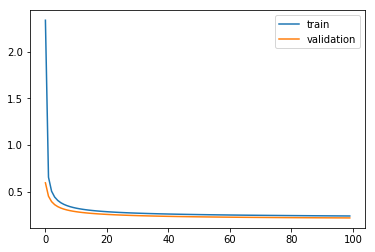

In [12]:
plot_train_vs_validation_loss(train_loss, eval_loss)

#### Validation vs training loss without first 10 steps

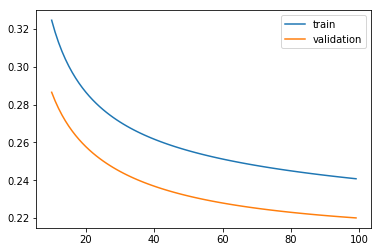

In [13]:
plot_train_vs_validation_loss(train_loss, eval_loss, offset=10)

## Multilayer Perceptron

In [14]:
num_hidden = 64

def mlp_out(num_hidden):
  data = sym.Variable('data')

  hid_in = sym.FullyConnected(
    data,
    name='hidden_in',
    num_hidden=num_hidden)
  hid_out = sym.Activation(
    hid_in,
    act_type='relu',
    name='hidden_out')

  softmax_in = sym.FullyConnected(
    data=hid_out,
    name='softmax_in',
    num_hidden=category_count)
  return sym.SoftmaxOutput(softmax_in, name='softmax')

In [15]:
mlp = mod.Module(symbol=mlp_out(num_hidden))

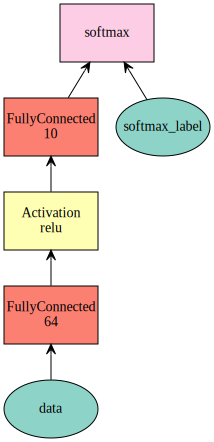

In [16]:
mx.viz.plot_network(mlp.symbol)

In [17]:
mlp_train_log_list = []
mlp_eval_log_list = []

%time mlp.fit(\
  train_iter,\
  eval_data=valid_iter,\
  eval_metric='ce',\
  batch_end_callback=log_to_list(mlp_train_log_list),\
  eval_batch_end_callback=log_to_list(mlp_eval_log_list, data_type='Valid'),\
  num_epoch=num_epoch)

CPU times: user 1min 21s, sys: 3.28 s, total: 1min 25s
Wall time: 37.6 s


### Validation vs training loss for MLP 

In [18]:
mlp_train_loss = [msg[1][4] for msg in mlp_train_log_list]
mlp_eval_loss = [msg[1][4] for msg in mlp_eval_log_list]

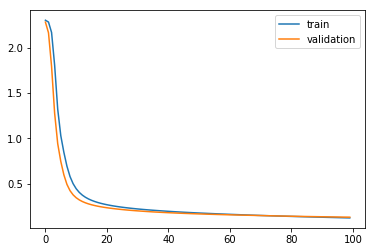

In [19]:
plot_train_vs_validation_loss(mlp_train_loss, mlp_eval_loss)

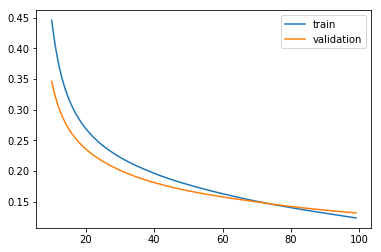

In [20]:
plot_train_vs_validation_loss(mlp_train_loss, mlp_eval_loss, offset=10)

## Accuracy

In [21]:
evaluate_classifier(mlp)

accuracy on train set:
0.96
accuracy on validation set:
0.954
accuracy on test set:
0.951


## Different optimizers/hyperparameters

In [32]:
customized_mlp = mod.Module(symbol=mlp_out(num_hidden))

customized_mlp.bind(data_shapes=train_iter.provide_data, label_shapes=train_iter.provide_label)
customized_mlp.init_params(initializer=mx.init.Xavier(magnitude=2.))

In [33]:
customized_mlp_train_log_list = []
customized_mlp_eval_log_list = []

%time customized_mlp.fit(\
  train_iter,\
  eval_data=valid_iter,\
  optimizer='adam',\
  optimizer_params={'learning_rate': 0.001, 'wd': 1e-3},\
  eval_metric='ce',\
  batch_end_callback=log_to_list(customized_mlp_train_log_list),\
  eval_batch_end_callback=log_to_list(customized_mlp_eval_log_list, data_type='Valid'),\
  num_epoch=50)

/home/semantive/Projects/notebooks/examples-counterexamples/venv/lib/python3.5/site-packages/mxnet/module/base_module.py:464: UserWarning: Parameters already initialized and force_init=False. init_params call ignored.
  allow_missing=allow_missing, force_init=force_init)


CPU times: user 43.2 s, sys: 2.14 s, total: 45.3 s
Wall time: 19.6 s


In [36]:
customized_mlp_train_loss = [msg[1][4] for msg in customized_mlp_train_log_list]
customized_mlp_eval_loss = [msg[1][4] for msg in customized_mlp_eval_log_list]

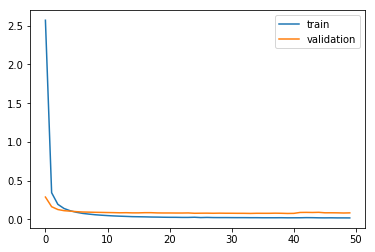

accuracy on train set:
0.996
accuracy on validation set:
0.976
accuracy on test set:
0.972


In [37]:
plot_train_vs_validation_loss(customized_mlp_train_loss, customized_mlp_eval_loss)
evaluate_classifier(customized_mlp)